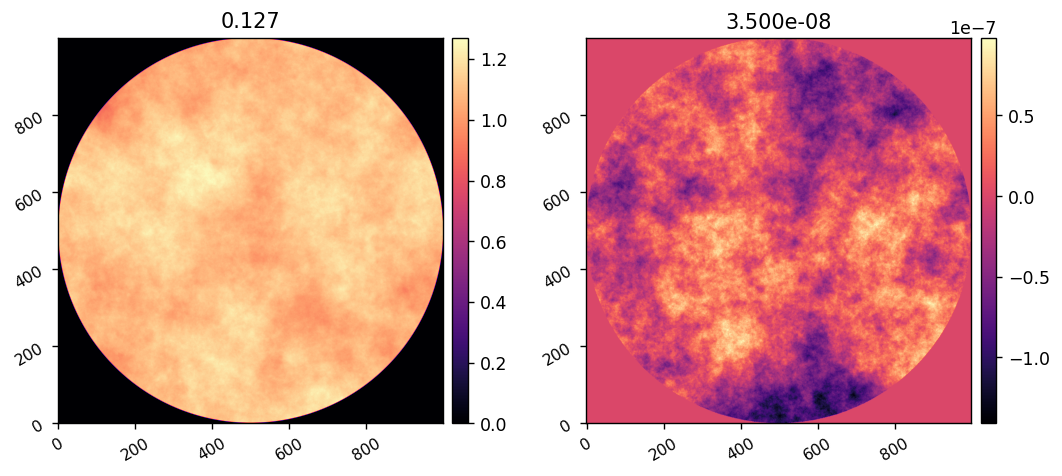

In [27]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = 650e-9/2/np.pi * xp.angle(WFE)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

# Establish the forward model parameters.

In [4]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE

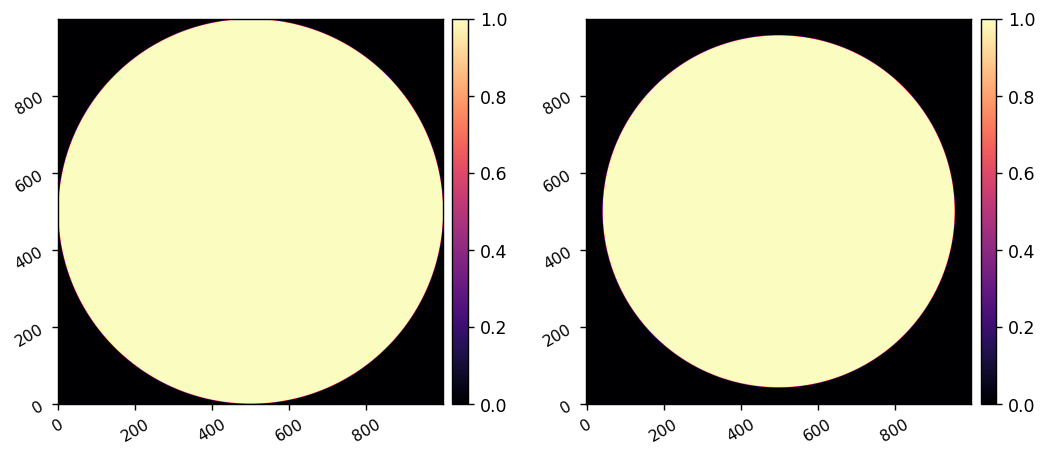

In [3]:
imshow2(m.APERTURE, m.LYOT, npix=m.npix)

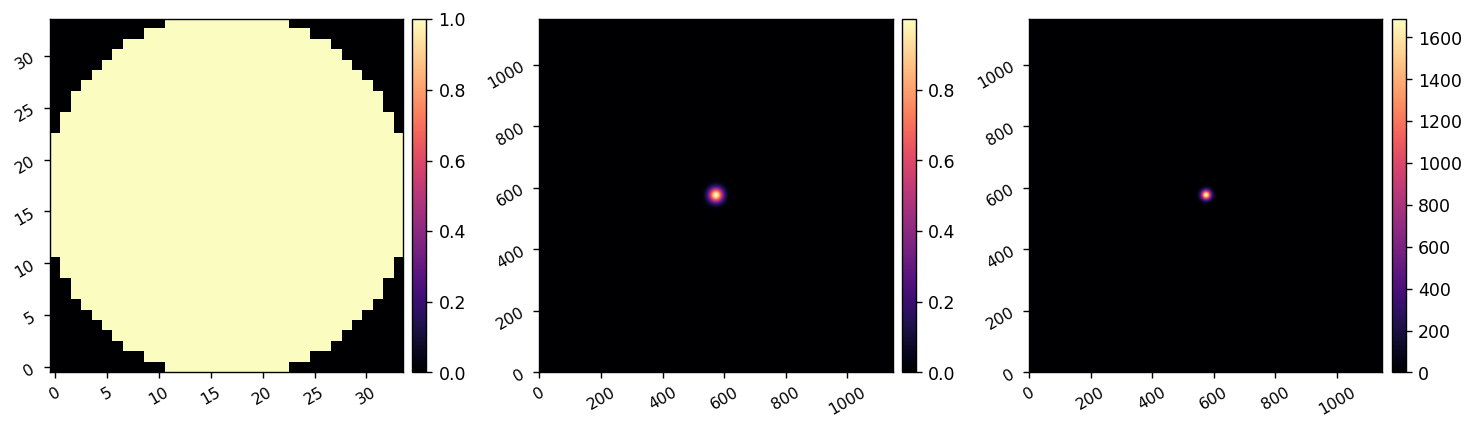

In [5]:
imshow3(m.dm_mask, m.inf_fun, xp.abs(m.inf_fun_fft))

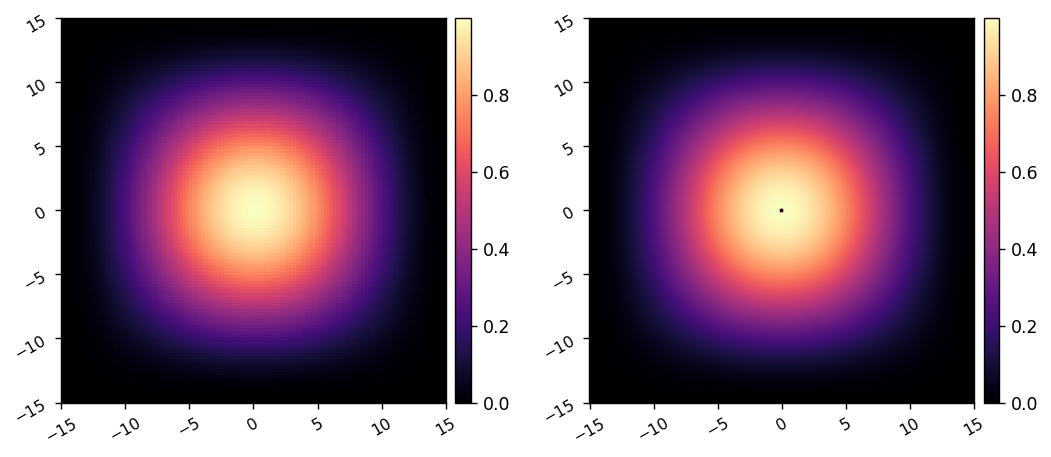

In [5]:
imshow2(m.lres_window, m.hres_window, npix1=m.lres_win_size,
        pxscl1=m.lres_sampling, pxscl2=m.hres_sampling)

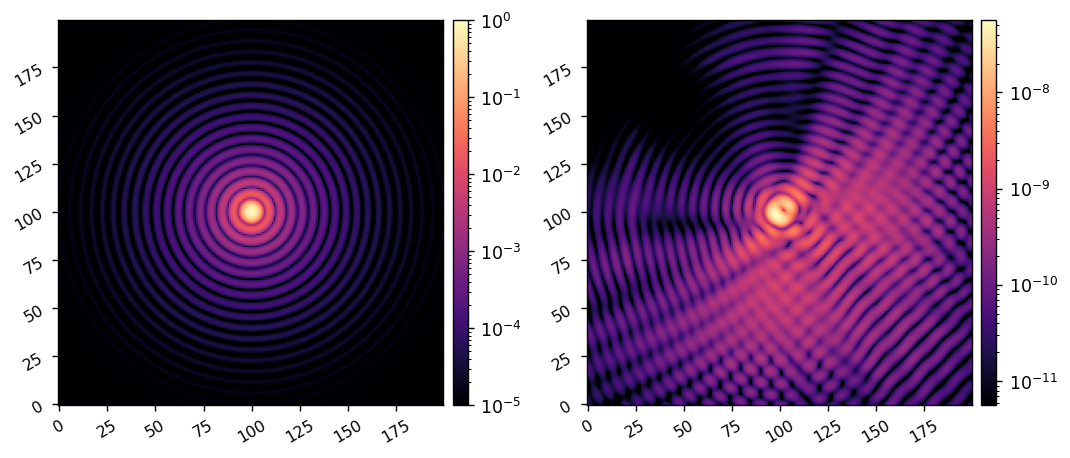

In [5]:
m.Imax_ref = 1
test_psf = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=False, use_wfe=False))**2
m.Imax_ref = xp.max(test_psf)
test_coro_im = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=True, use_wfe=False))**2
imshow2(test_psf/m.Imax_ref, test_coro_im, lognorm=True, vmin1=1e-5, vmin2=xp.max(test_coro_im)/1e4)

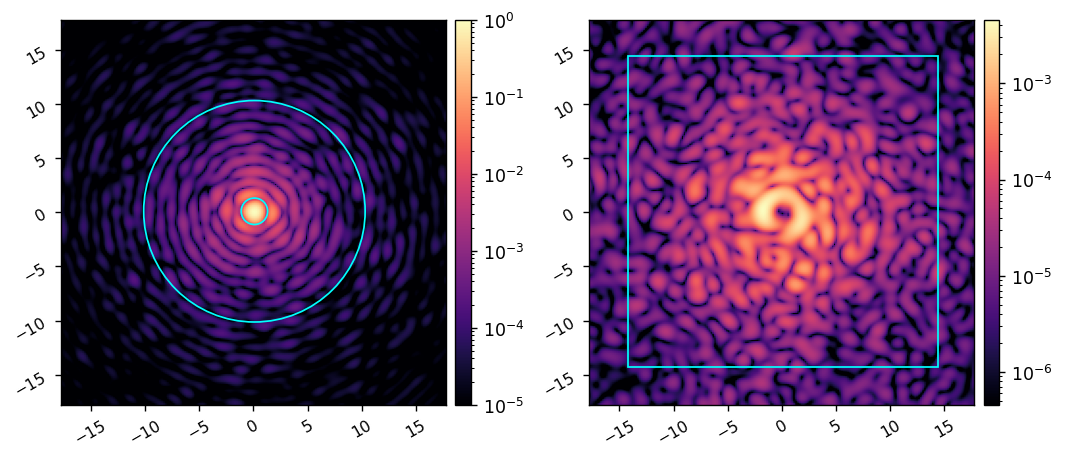

In [8]:
acts = np.zeros(m.Nacts)

# waffle_command = 20e-9 * xp.ones((m.Nact,m.Nact))
# waffle_command[1::2, ::2] *= -1
# waffle_command[::2, 1::2] *= -1
# acts = ensure_np_array(waffle_command[m.dm_mask]) 

m.Imax_ref = 1
ref_psf = xp.abs(m.forward(np.zeros(m.Nacts), use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow2(ref_psf/m.Imax_ref, ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)


# Test normal EFC

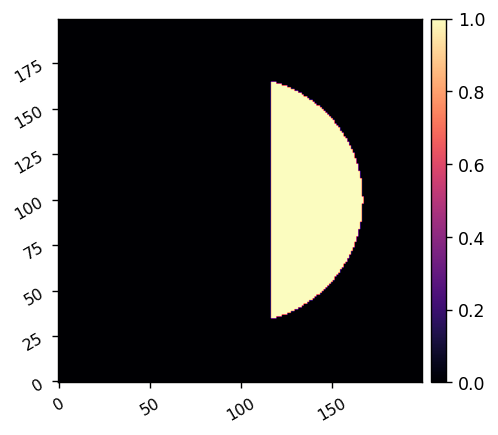

In [9]:
m.create_control_mask()
imshow1(m.control_mask)

In [13]:
reload(ad_scoob)

poke_modes = ad_scoob.create_poke_modes(m)

In [21]:
reload(ad_scoob)

jac = ad_scoob.compute_jacobian(m, poke_modes)


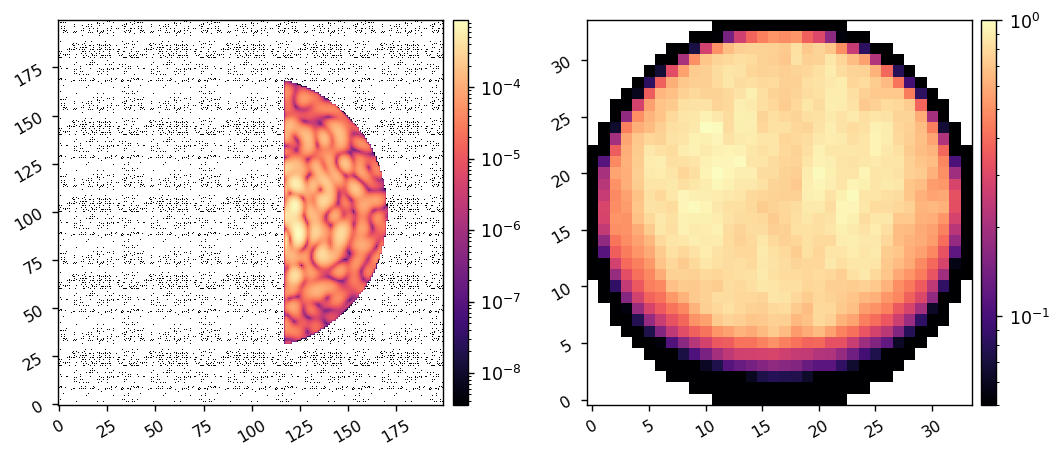

In [25]:
responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.sum(xp.square(xp.abs(responses.dot(poke_modes.reshape(m.Nacts, m.Nact**2)))), axis=0)).reshape(m.Nact,m.Nact)
dm_response /= dm_response.max()
imshow2(m.control_mask*ref_coro_im, dm_response, lognorm=True, vmin2=5e-2)

In [26]:
all_ims = []
all_efs = []
all_commands = []

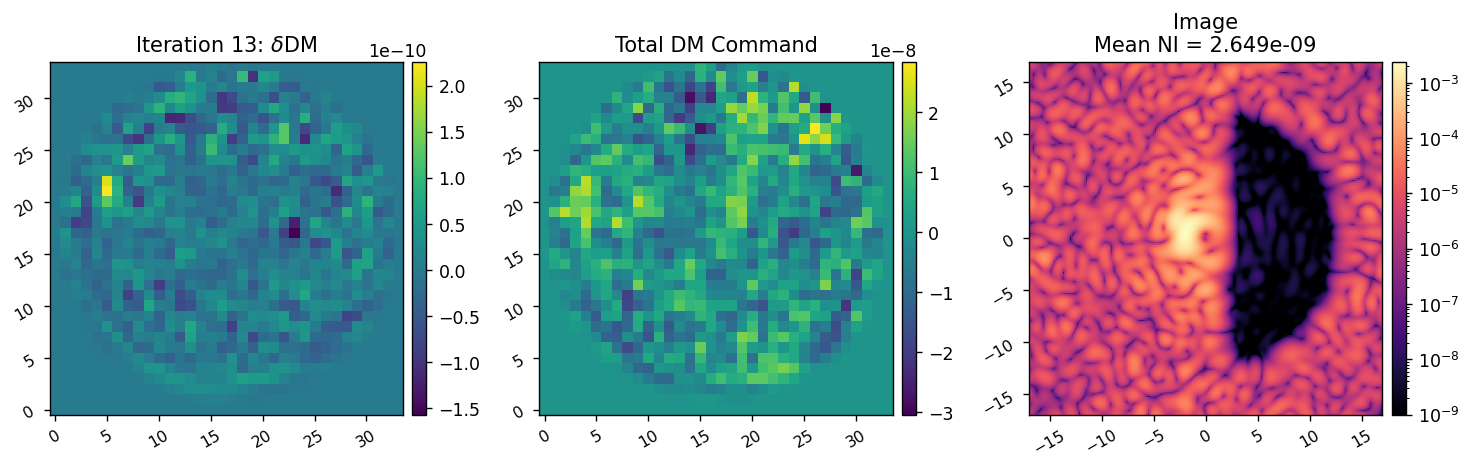

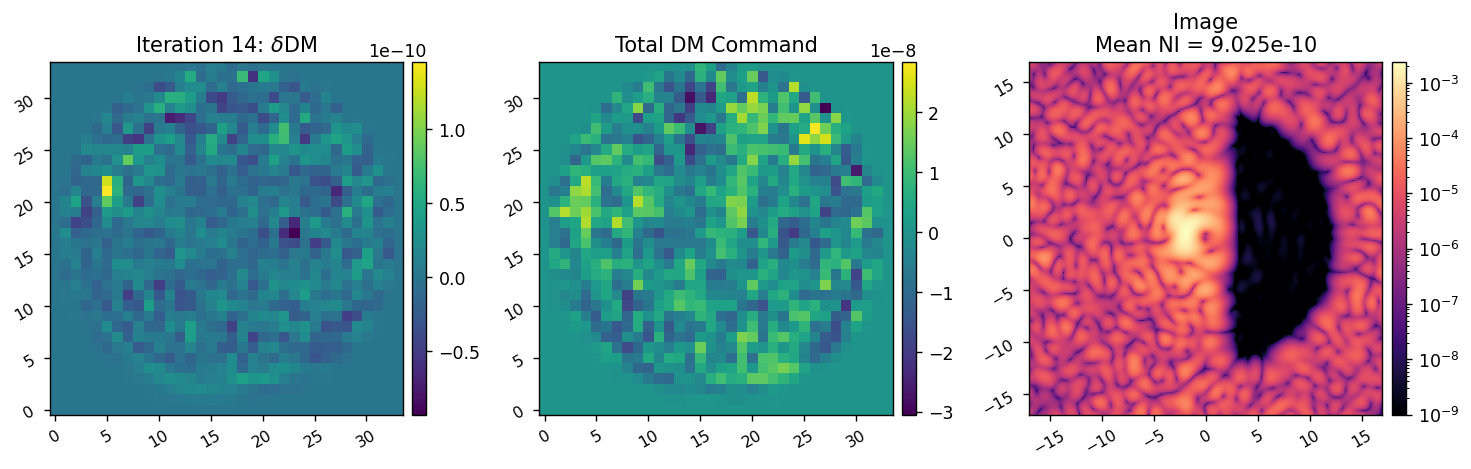

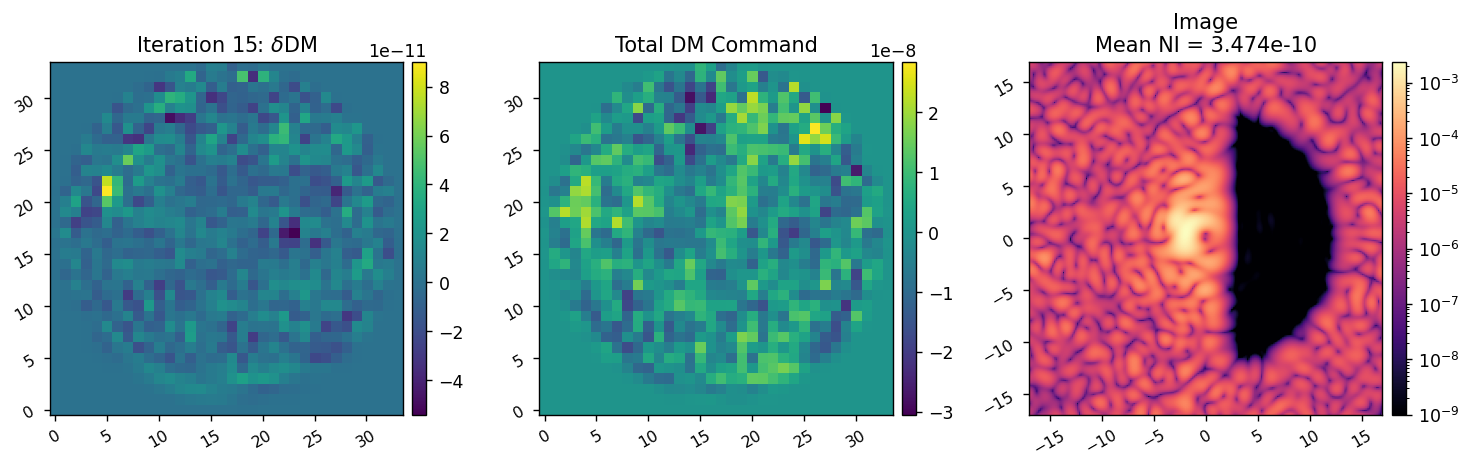

In [34]:
reload(ad_scoob)

cm = ad_scoob.beta_reg(jac, -2.5)
# cm = ad_scoob.beta_reg(jac, -4.5)

all_ims, all_efs, all_commands = ad_scoob.efc(m,
                                              cm, 
                                              Nitr=3, 
                                              nominal_command=all_commands[-1], 
                                              all_ims=all_ims, 
                                              all_efs=all_efs,
                                              all_commands=all_commands,
                                              )



# Test minimzation with L-BFGS-B

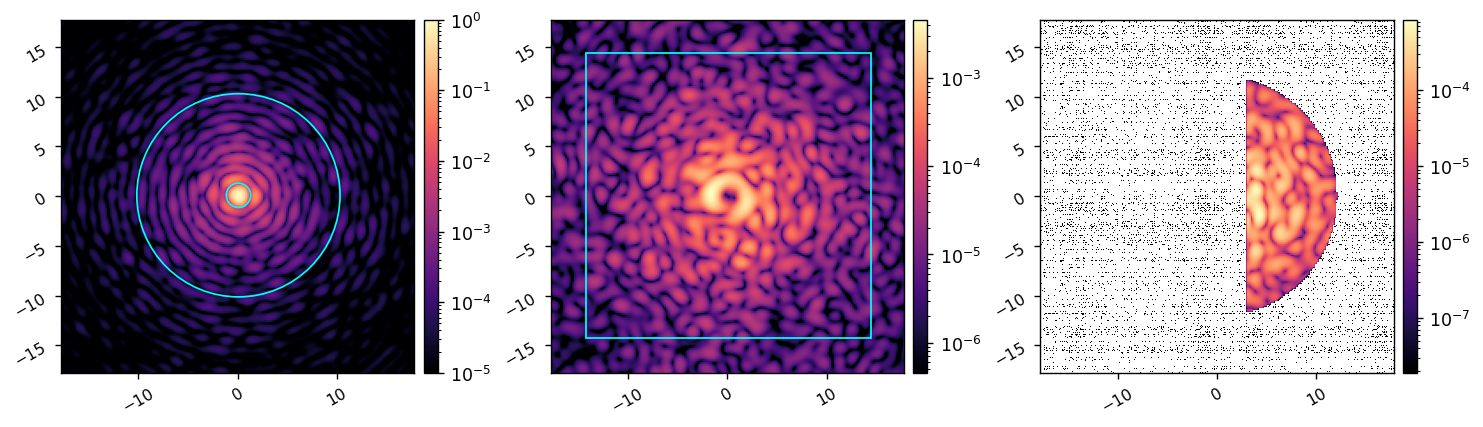

In [58]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE
# m.det_rotation = 45
m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow3(ref_psf/m.Imax_ref, ref_coro_im, m.control_mask*ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True,  vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

In [14]:
utils.save_fits('test_acts.fits', res.x)

Saved data to:  test_acts.fits


0.3260577535750728 0.0 0.3260577535750728 1.0


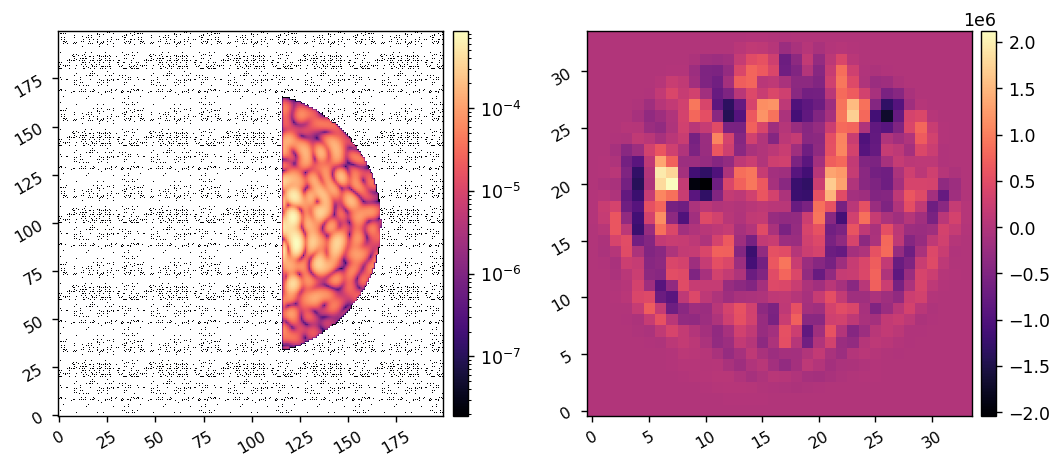

In [59]:
reload(ad_scoob)
del_acts = np.zeros(m.Nacts)
acts = np.zeros(m.Nacts)
# acts = fits.getdata('test_acts.fits')
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-2

J, dJ_dA = ad_scoob.val_and_grad(del_acts, 
                                 m,
                                 acts, 
                                 E_ab,
                                 r_cond,
                                 verbose=True,
                                )

current_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2
dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(m.control_mask*current_im, dm_grad, lognorm1=True)

# Does E_ep_k-1 contain the wavefront contribution from the total accumulated DM command?

In [60]:
reload(ad_scoob)

bfgs_tol = 1e-3
bfgs_opts = {
    # 'maxiter':20,
    # 'maxls':30, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
    'disp':True, 
}

# del_acts0 = np.zeros(m.Nacts)
# acts = np.zeros(m.Nacts)
# E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
# r_cond = 5e-2
# E_target = 0
# E_model_nom = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=False) * m.control_mask)

# res = minimize(ad_scoob.val_and_grad, 
#                 jac=True, 
#                 x0=del_acts0,
#                 args=(m, E_ab, r_cond, E_target, E_model_nom, True), 
#                 method='L-BFGS-B',
#                 tol=bfgs_tol,
#                 options=bfgs_opts,
#                 )


del_acts0 = np.zeros(m.Nacts)
acts = np.zeros(m.Nacts)
# acts = fits.getdata('test_acts.fits')
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-2

res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )

0.3260577535750728 0.0 0.3260577535750728 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.11492D+06
0.0083225428303268 23668639053.254436 0.3260577535750728 72590327307.80684
0.06134013268584927 41.153491120571005 0.3260577535750728 126.40346932822561
0.9929926755141323 2.4918916090011844 0.3260577535750728 10.687935638104504


 This problem is unconstrained.


6.263892996332727 0.2251079129219569 0.3260577535750728 19.90138507091392
4.968615694703323 0.011545627003547469 0.3260577535750728 15.273862581403757
0.07120877400179428 0.0004619425886588006 0.3260577535750728 0.21980988277265834

At iterate    1    f=  2.19810D-01    |proj g|=  1.09008D+06
0.021921483476793888 0.0004027234677050387 0.3260577535750728 0.06846703290973548

At iterate    2    f=  6.84670D-02    |proj g|=  2.53724D+05
0.011425676718435293 0.0004572215372778127 0.3260577535750728 0.036444151765822504

At iterate    3    f=  3.64442D-02    |proj g|=  1.79946D+05
0.0060826605182410535 0.0005376098459030012 0.3260577535750728 0.02030398078731711

At iterate    4    f=  2.03040D-02    |proj g|=  1.15403D+05
0.003558330692387428 0.0006130559140021963 0.3260577535750728 0.012793397981346235

At iterate    5    f=  1.27934D-02    |proj g|=  1.39770D+05
0.002750257688441848 0.0006633431822161514 0.3260577535750728 0.01046931359009084

At iterate    6    f=  1.04693D-02    |proj 

6.667847721371633e-05 2.386985208663229e-07


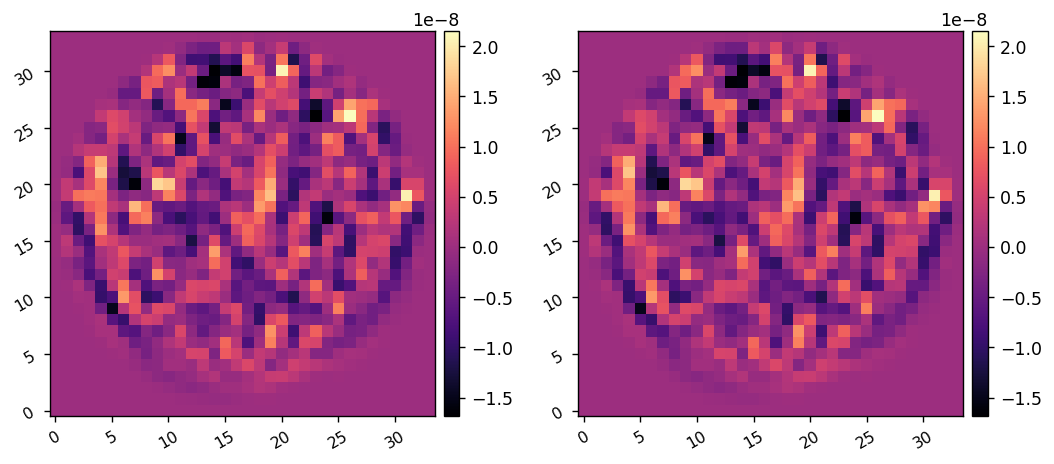

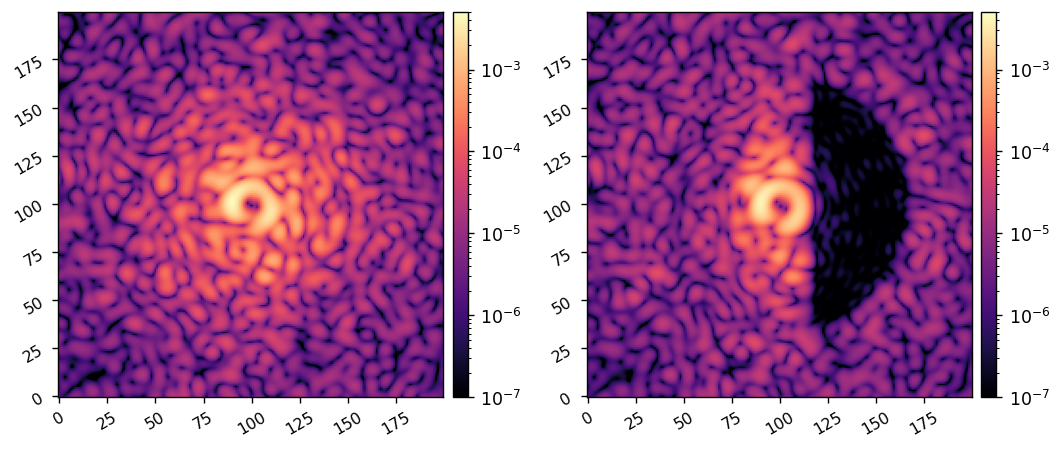

In [61]:
del_command = xp.zeros((m.Nact,m.Nact))
del_command[m.dm_mask] = res.x

total_command = xp.zeros((m.Nact,m.Nact))
total_command[m.dm_mask] = acts + res.x

prev_im = xp.abs(m.forward(acts, use_wfe=True))**2
new_im = xp.abs(m.forward(acts + res.x, use_wfe=True))**2

print(xp.mean(prev_im[m.control_mask]), xp.mean(new_im[m.control_mask]))
imshow2(del_command, total_command)
imshow2(prev_im, new_im, lognorm=True, vmin1=1e-7, vmin2=1e-7, vmax1=5e-3, vmax2=5e-3)

# Test a full EFC run with L-BFGS-B

In [62]:
reload(ad_efc)
reload(ad_scoob)


<module 'scoobpsf.ad_scoob' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/ad_scoob.py'>

In [83]:
all_ims = []
all_efs = []
all_commands = []

In [82]:
bfgs_tol = 1e-4
bfgs_opts = {
    # 'maxiter':50,
    # 'maxls':30, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
    'disp':False, 
}

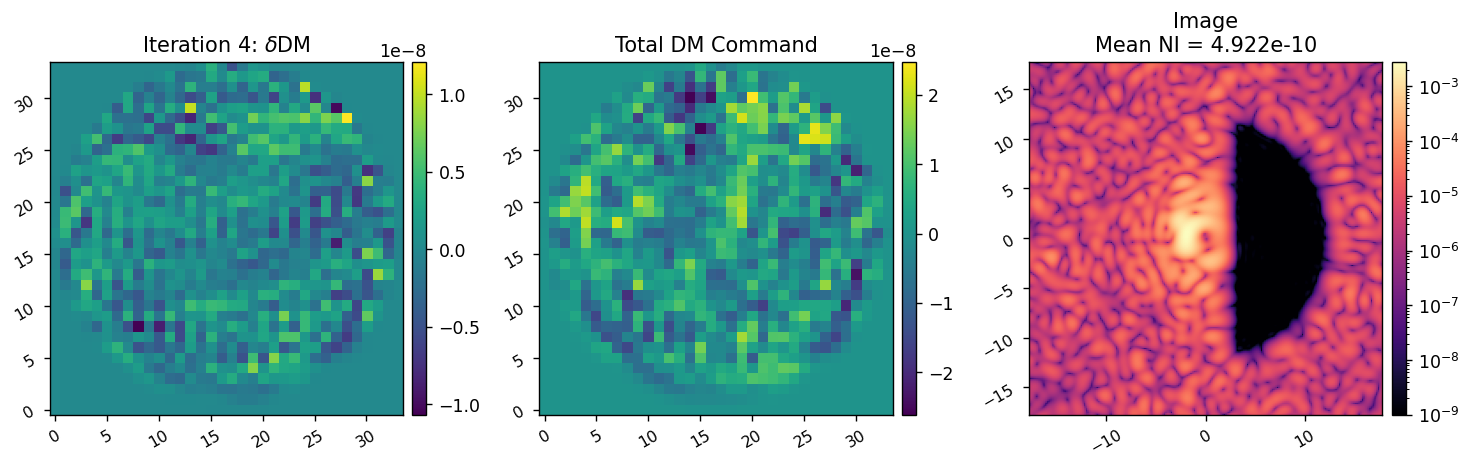

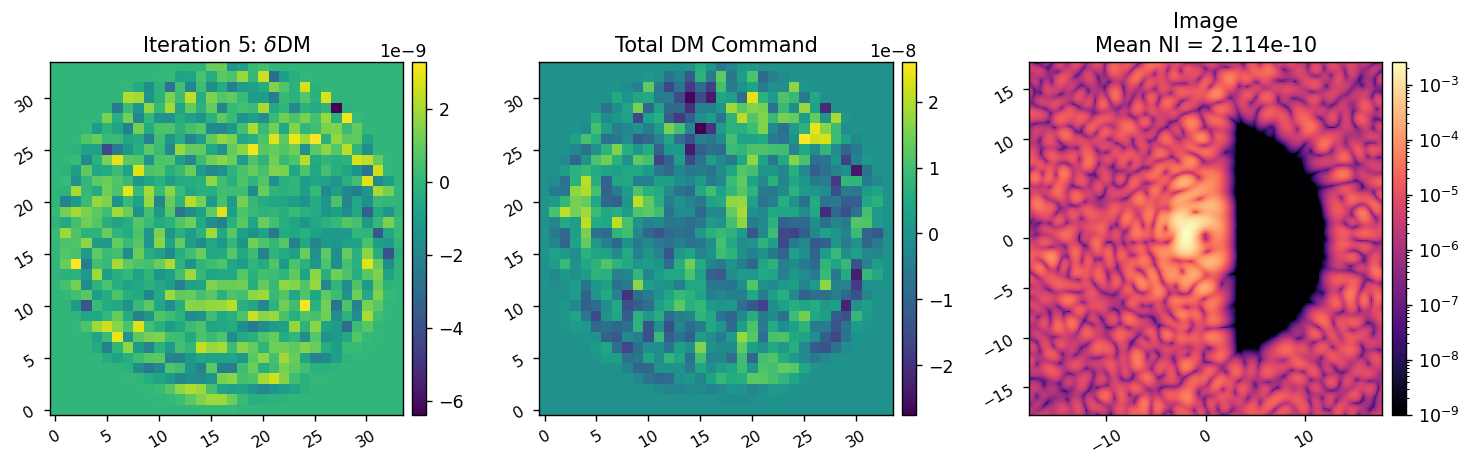

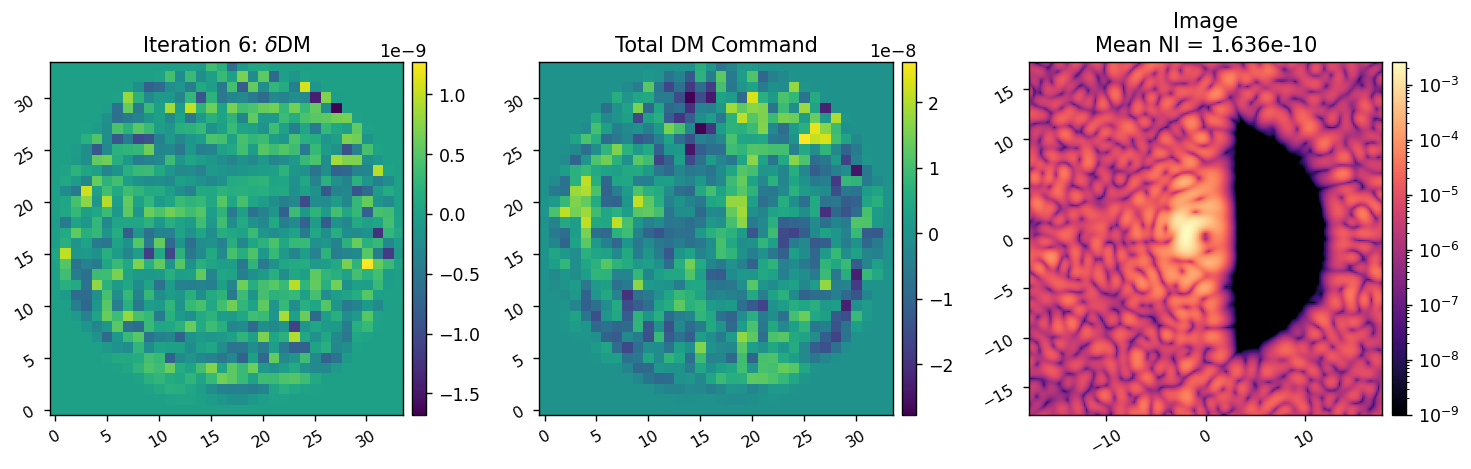

In [85]:
reload(ad_efc)
reload(ad_scoob)

# reg_cond = 1
# reg_cond = 1e-1
reg_cond = 1e-2
# reg_cond = 1e-3
reg_cond = 1e-4
# reg_cond = 1e-5

bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=reg_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )

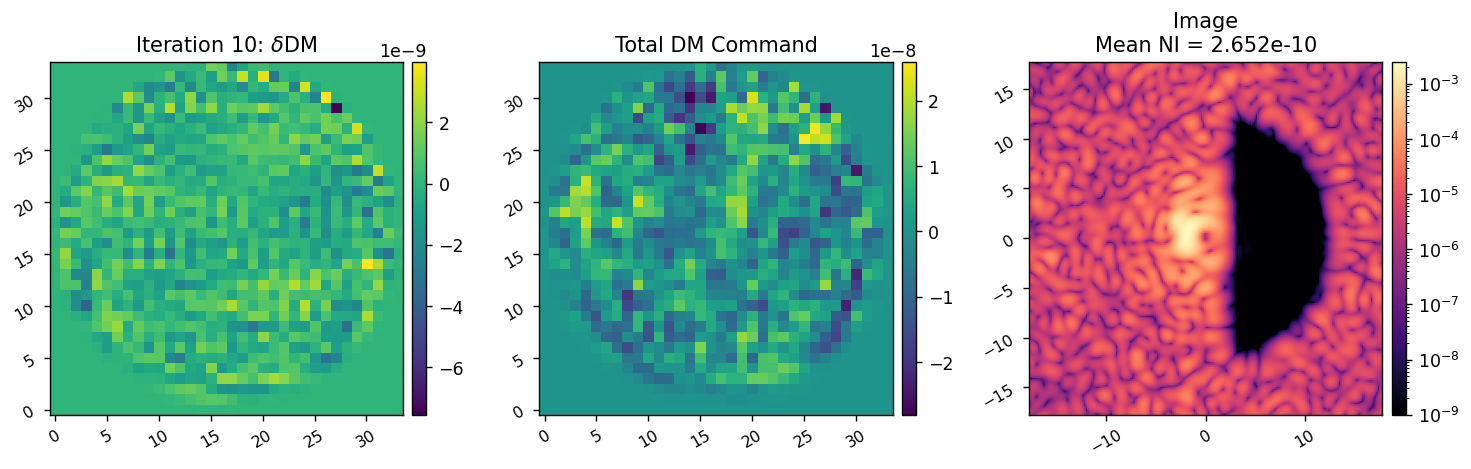

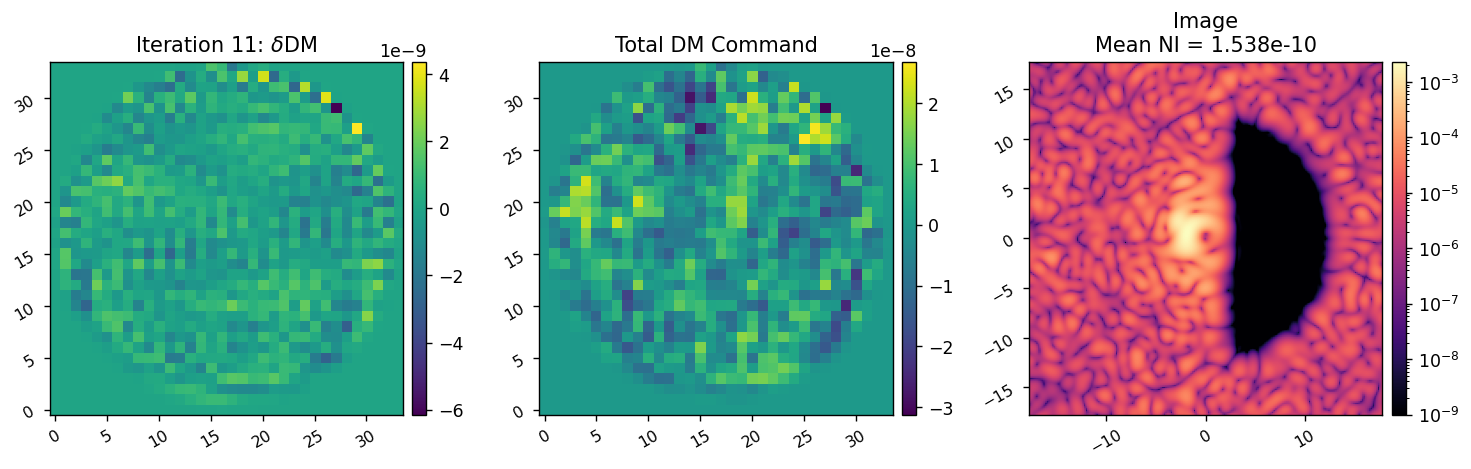

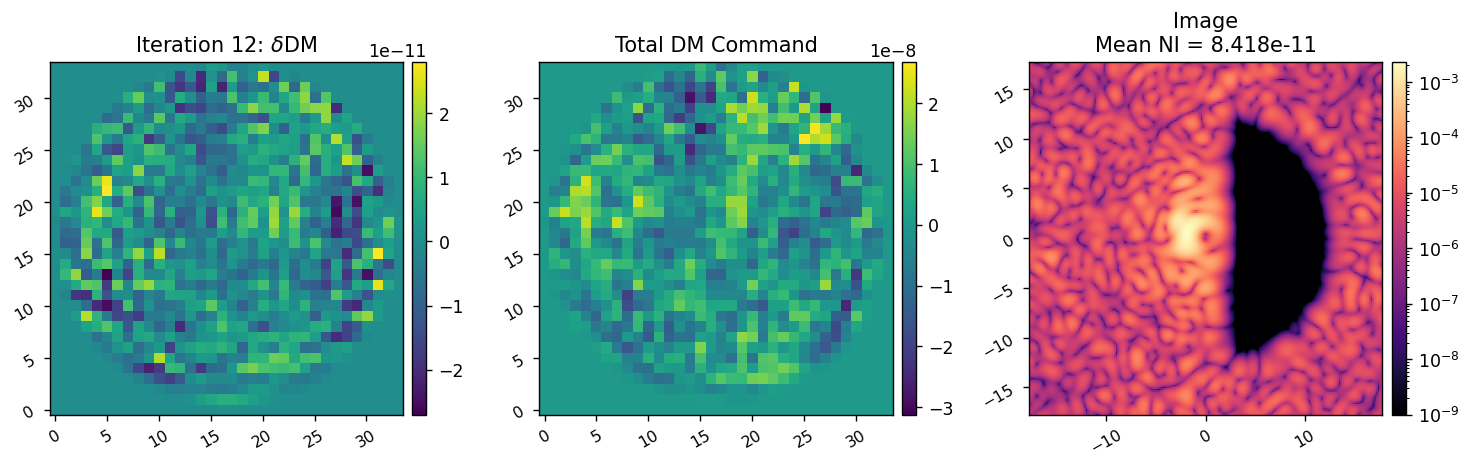

In [26]:
reload(ad_efc)
reload(ad_scoob)

# reg_cond = 1
# reg_cond = 1e-1
reg_cond = 1e-2
# reg_cond = 1e-3
# reg_cond = 1e-4

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=reg_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=0.5,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )